<a href="https://colab.research.google.com/github/filiphalys02/Modelowanie-w-naukach-o-ziemii/blob/main/geotherm_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zciągnięcie pakietu na osobisty dysk google aby zaoszczędzić czas przy restartach runtime. 

In [1]:
!apt-get install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (10.1.243-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
!pip install rpy2==3.5.1

%load_ext rpy2.ipython


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Komenda %lsmagic w Google Colab wyświetla listę wszystkich dostępnych w Colab magicznych poleceń (line i cell magic), czyli specjalnych poleceń pozwalających na bardziej zaawansowane korzystanie z notatnika.

In [3]:
%lsmagic

Available line magics:
%R  %Rdevice  %Rget  %Rpull  %Rpush  %alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%R  %%SVG  %%bash  %%bigquery  %%capture  %%debug  

Teraz zabawa z akceleracją GPU w Colab i R.
---

Zanim przeładujemy runtime sprawdźmy clinfo w terminalu 

In [4]:
!clinfo

Number of platforms                               1
  Platform Name                                   NVIDIA CUDA
  Platform Vendor                                 NVIDIA Corporation
  Platform Version                                OpenCL 3.0 CUDA 12.0.139
  Platform Profile                                FULL_PROFILE
  Platform Extensions                             cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_nv_kernel_attribute cl_khr_device_uuid cl_khr_pci_bus_info cl_khr_external_semaphore cl_khr_external_memory cl_khr_external_semaphore_opaque_fd cl_khr_external_memory_opaque_fd
  Platform Host timer resolution                  0ns
  Platform Extens

Widać że mamy dostęp do Tesla T4

Poniżej informujemy R że mamy swój katalog instalacyjny bibliotek R. Jeśli byśmy go nie mieli to za każdym restartem runtime koniecznym byłoby instalowanie i kompilowanie bibliotek!

In [5]:
!Rscript -e "install.packages('OpenCL')"

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/OpenCL_0.2-2.tar.gz'
Content type 'application/x-gzip' length 20881 bytes (20 KB)
downloaded 20 KB

* installing *source* package ‘OpenCL’ ...
** package ‘OpenCL’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -I"/usr/share/R/include" -DNDEBUG     -fvisibility=hidden -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-MkHsSu/r-base-4.2.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c buffer.c -o buffer.o
gcc -I"/usr/share/R/include" -DNDEBUG     -fvisibility=hidden -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-MkHsSu/r-base-4.2.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c ocl.c -o ocl.o
gcc -I"/usr/share/R/include" -DNDEBUG     -fvisibility=hidden -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-MkHsSu/r-base-4.2.3=. -fstack-p

In [6]:
%%R
library(OpenCL)
#library(animation)

Zacznijmy od OpenCL. Moża korzystać z GPU łatwiej ale z OpenCL można to zrobić najbardziej uniwersalnie. Oczywiście za cenę konieczności własnoręcznego napisania kerneli.   

R wants to show a message


Time difference of 6.212341 secs


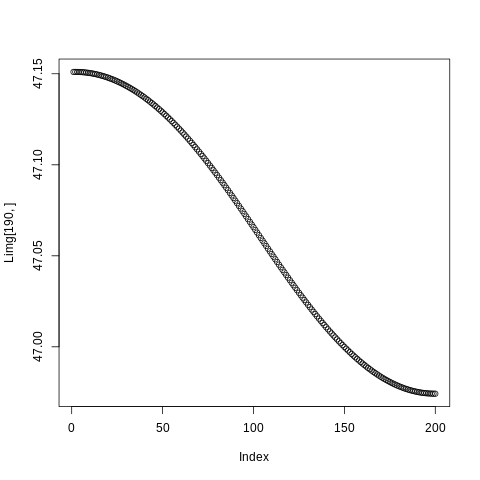

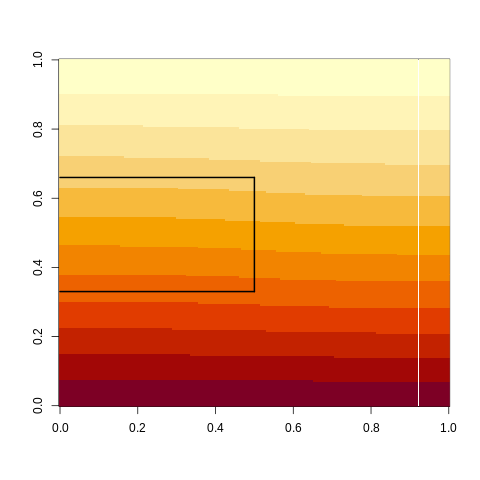

In [9]:
%%R

#jądro obliczeniowe 
geo_cl <- c(
  '
    __kernel void geotherm(
      __global numeric* output,
      const unsigned int size,
      int inN,
      __global double* infl, //wektor z parametrami float
      __global double* va,
      __global double* vL
    )
    {
      // iterator - uwaga na inne oznaczenie komentarzy!
      size_t i = get_global_id(0); // i - globalny numer wątku 

      //zmienne pomocnicze dt i h^2
      float dt;
      float h2;

      dt=infl[0];
      h2=infl[1];


        if (i%inN==0){ //góra
          output[i] =0;
        }
        else if(i%inN==inN-1) { //dół
          output[i]=50;    
        }
        else if(i<inN) { //lewa - ŹLE, TO MACIE WYMYŚLEĆ 
          output[i]=vL[i+inN];    
        }
        else if(i>size-1-inN) { //prawa - ŹLE, TO MACIE WYMYŚLEĆ 
          output[i]=vL[i-inN];    
        }
        else{
          output[i]=(1.0-(4.0*dt*va[i])/(h2))*vL[i] + dt*va[i]* ((vL[i-1]+vL[i+1]+vL[i-inN]+vL[i+inN])/(h2));  
        }
     barrier(CLK_GLOBAL_MEM_FENCE); //czekamy na wszystkie wątki aby uniknać zbyt wczesnego nadpisania danych
     vL[i]=output[i]; // przepisanie starej macierzy nową 
    }
  '
)
#geo_cl



library(OpenCL)
platform <- oclPlatforms()[[1]]
device <- oclDevices(platform)[[1]]
ctx <- oclContext(device)

#platform
#device
#ctx

geotherm_kernel <- oclSimpleKernel(
  # context 
  ctx, 
  # nazwa funkcji 
  name='geotherm', 
  # kod do wykonania i rodzaj wyjścia
  code=geo_cl, 
  output.mode='numeric'
)

#wymiar
N=200

#krok
h<-5

#inicjalizacja macierzy dla kroku nowego
L<-matrix(nrow=N,ncol=N,0)

#model alfa - ciało w “lewej środkowej” części modelu 
a<-matrix(nrow=N,ncol=N,0.002)
a[66:132,1:(N/2)]<-rep(0.006,67*(N/2))
#image(t(apply(a, 2, rev)))


#max a do stabilności 
a_max<-max(a)
#krok czasowy
dt<-h^2/(4*a_max)
#czas symulacji 
t<-0
#warunki brzegowe 
L[,1]<-rep(0,N)
L[,N]<-rep(0,N)
L[1,]<-rep(0,N)
L[N,]<-rep(50,N)

niter<-100000

start<-Sys.time()

#geo_kernel transfer danych na kartę 
vL_buf <- as.clBuffer(as.numeric(L), ctx)
va_buf <- as.clBuffer(as.numeric(a), ctx)
#wektor ze zmiennymi pomocniczymi (od razu h^2)
infl_buf <- as.clBuffer(as.numeric(c(dt,h*h)), ctx)


#wykonanie kernela niter razy. Dlaczego to działa?
for (k in 1:niter){
cl_ans <- oclRun(
  kernel=geotherm_kernel, 
  size=N^2, 
  inN=as.integer(N),
  infl=infl_buf, 
  va=va_buf, 
  vL=vL_buf
)
}

stop<-Sys.time()

#powrót z wektora na macierz
v<-as.numeric(cl_ans)
Limg<-matrix(v,ncol=N,nrow=N)

#narysowanie przekroju poziomego na poziomie 190 (*5 metrów) 
plot(Limg[190,])

#rysunek
Limg <- apply(Limg, 2, rev)
image(t(Limg))
lines(c(0,0.5),c(0.33,0.33),lwd=2)
lines(c(0,0.5),c(0.66,0.66),lwd=2)
lines(c(0.5,0.5),c(0.33,0.66),lwd=2)

#wypisanie czasu pracy na karcie
print(stop-start)

WOW!
---
